In [1]:
from tensorflow.keras.models                     import Sequential
from tensorflow.keras.layers                     import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
from tensorflow.keras                            import utils
from tensorflow.keras.preprocessing              import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks                  import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection                     import train_test_split
from google.colab                                import files
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
file = files.upload()
p = os.path.abspath('kaggle.json')
print(p)

Saving kaggle.json to kaggle.json
/content/kaggle.json


In [3]:
!pip install kaggle

In [7]:
!mkdir ~/.kaggle
p = os.path.abspath('.kaggle')
print(p)
!ls

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/content/.kaggle
kaggle.json  sample_data


In [8]:
!mv kaggle.json ~/.kaggle
!kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 36.6MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 84.2MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 100MB/s]


In [9]:
!ls

sample_data  sample_submission.csv  test.csv.zip  train.csv.zip


In [12]:
!unzip '/content/train.csv.zip'
!unzip '/content/test.csv.zip'

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                


In [13]:
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

In [14]:
train_dataset[0:5]
x_train = train_dataset[:, 1:]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1) 

In [15]:
x_train /= 255.0
x_train[1].shape
y_train = train_dataset[:, 0]
y_train[:5]
y_train = utils.to_categorical(y_train)


In [16]:
random_seed = 10
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

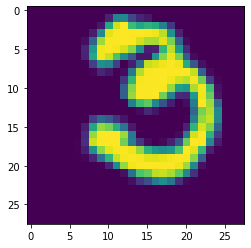

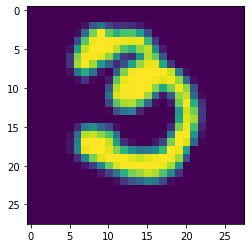

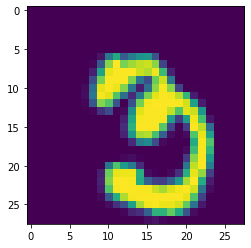

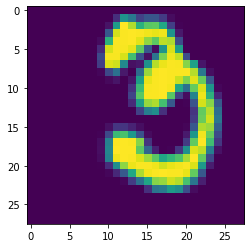

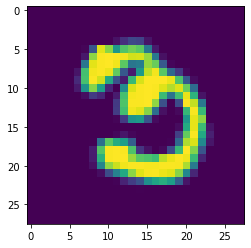

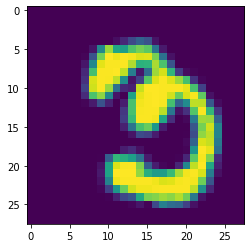

In [18]:
i = 0
data = X_train[0]
data = np.expand_dims(data, axis=0)
for batch in datagen.flow(data, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0][:,:,0])
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [19]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [20]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [21]:
сheckpoint = ModelCheckpoint('content/mnist-cnn.h5', 
                              monitor='val_acc', 
                              save_best_only=True,
                              verbose=1)

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
batch_size = 256
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                    epochs=50,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/50
147/147 [==============================] - 15s 102ms/step - loss: 0.5858 - accuracy: 0.8057 - val_loss: 0.0762 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 2/50
147/147 [==============================] - 14s 94ms/step - loss: 0.1598 - accuracy: 0.9513 - val_loss: 0.0502 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 3/50
147/147 [==============================] - 14s 96ms/step - loss: 0.1244 - accuracy: 0.9638 - val_loss: 0.0416 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 4/50
147/147 [==============================] - 14s 98ms/step - loss: 0.0971 - accuracy: 0.9702 - val_loss: 0.0378 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 5/50
147/147 [==============================] - 14s 98ms/step - loss: 0.0857 - accuracy: 0.9747 - val_loss: 0.0317 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 6/50
147/147 [==============================] - 15s 99ms/step - loss: 0.0766 - accuracy: 0.9770 - val_loss: 0.0249 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 7/50
147/147 [==============================] - 14s

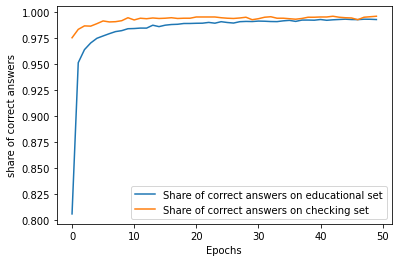

In [34]:
plt.plot(history.history['accuracy'], 
         label='Share of correct answers on educational set')
plt.plot(history.history['val_accuracy'], 
         label='Share of correct answers on checking set')
plt.xlabel('Epochs')
plt.ylabel('share of correct answers')
plt.legend()
plt.show()

In [24]:
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)
x_test = x_test / 255.0

In [25]:
predictions = model.predict(x_test)
predictions[:5]

array([[1.57576304e-13, 2.76230150e-14, 1.00000000e+00, 8.52083855e-12,
        6.35342993e-12, 1.84115308e-18, 8.72565773e-14, 1.93794915e-12,
        5.83371676e-12, 6.57250838e-13],
       [1.00000000e+00, 1.67615338e-13, 1.13583233e-10, 2.14445852e-13,
        8.96656360e-11, 8.99195822e-12, 1.27241398e-10, 9.58184487e-12,
        2.65388041e-11, 8.25371682e-09],
       [1.76440432e-10, 1.33836773e-08, 1.52228068e-07, 1.00900506e-08,
        2.95845064e-04, 2.44648551e-10, 1.72057160e-11, 1.77245579e-06,
        2.92708046e-06, 9.99699235e-01],
       [9.99196589e-01, 6.73534188e-08, 1.19971919e-05, 1.72900457e-07,
        1.65530844e-06, 2.20852962e-06, 1.02248932e-05, 2.40324880e-06,
        3.95255993e-05, 7.35142443e-04],
       [4.21722696e-16, 3.75276199e-12, 1.02188105e-10, 9.99999881e-01,
        2.16359801e-18, 4.12508305e-10, 6.20656846e-13, 2.42268792e-12,
        1.18146907e-07, 4.73104556e-10]], dtype=float32)

In [29]:
predictions = np.argmax(predictions, axis=1)
predictions[:5]

array([2, 0, 9, 0, 3])

In [30]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [31]:
np.savetxt('submission.csv', out, header="ImageId,Label", 
            comments="", fmt="%d,%d")

In [ ]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv